In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
from tqdm.notebook import tqdm

from west_ic_antenna import WestIcrhAntenna
from west_ic_antenna.topica import TopicaResult

# Plasma Coupling Using TOPICA Results

In this example, we use the the TOPICA front-face coupling calculations which have been used during the design of the WEST ICRH Antenna. TOPICA results are typically given as Z-matrix, which here have been converted into S-parameter files to be imported in the antenna RF model. 

TOPICA results are given for single frequency (55 MHz). If the antenna is defined for a frequency band, the S-parameters of the TOPICA front-face are then duplicated behind the hood for all the frequencies of the frequency band. 

The following function generates a scikit-rf Network object, interpolated from TOPICA results obtained during the design of the WEST ICRH Antenna. These Network that can be used later as the input front-face of the antenna.  

In [4]:
# generates a 2 Ohm coupling resistance front-face
WestIcrhAntenna.TOPICA_front_face(Rc=2, mode='L')

4-Port Network: 'S_TSproto12_55MHz_Profile1',  55000000.0-55000000.0 Hz, 1 pts, z0=[46.7+0.j 46.7+0.j 46.7+0.j 46.7+0.j]

In the example below, we build a WEST ICRH antenna model from a TOPICA-interpolated result and we match the antenna

In [117]:
# Antenna Frequency band defined as single point
f0 = 55e6
freq = rf.Frequency(f0, f0, npoints=1, unit='Hz')
# generate antenna front face
TOPICA_front_face = WestIcrhAntenna.TOPICA_front_face(Rc=2, mode='L')
#TOPICA_front_face = rf.Network('../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile1.s4p')
# build the antenna model
antenna = WestIcrhAntenna(frequency=freq, front_face=ff)
# match the antenna in dipole
power = [1, 1]
phase = [0, np.pi]

C_match = antenna.match_both_sides(f_match=f0, power=power, phase=phase)

Looking for individual solutions separately for 1st guess...
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [56.56365762 45.75301262]
True solution #1: [55.98256028 45.75805833]
Searching for the active match point solution...
Reducing search range to +/- 2pF around individual solutions
True solution #1: [55.2314647  44.22049285 54.91290648 43.75805833]


In [120]:
C_match

[55.23146469964239, 44.220492846794556, 54.912906479915755, 43.75805833440046]

In [122]:
_Cs = C_match.copy()
_Cs[0] += 2
_Cs[1] -= 2
_Cs[2] += 2
_Cs[3] -= 2

for idx in np.arange(100):
    _Cs_left, _Cs_right = antenna.capacitor_predictor(power, phase, Cs=list(_Cs), K=0.3 )
    _Cs = np.array([_Cs_left, _Cs_right]).reshape(4)
    print(_Cs, '->', antenna.vswr_act(power, phase, Cs=list(_Cs)))

[57.24348474 42.38029181 56.93196223 41.90864916] -> [[1.48517091 1.45864571]]
[57.25209586 42.53750054 56.94858509 42.05796714] -> [[1.46777711 1.44865192]]
[57.25731492 42.69184824 56.96273956 42.20584768] -> [[1.44991143 1.43816891]]
[57.25917622 42.84306716 56.97439555 42.35212453] -> [[1.431667   1.42723053]]
[57.25773226 42.99089509 56.98352863 42.49663022] -> [[1.4131395  1.41587262]]
[57.25305416 43.13507815 56.99012035 42.63919654] -> [[1.39442594 1.40413279]]
[57.24523179 43.27537368 56.99415851 42.77965509] -> [[1.37562351 1.3920502 ]]
[57.2343735  43.41155324 56.99563751 42.91783781] -> [[1.35682821 1.3796654 ]]
[57.22060539 43.54340568 56.9945586  43.05357762] -> [[1.33813368 1.36702014]]
[57.20407022 43.67073996 56.99093018 43.18670913] -> [[1.31962997 1.35415721]]
[57.18492582 43.79338789 56.98476811 43.31706931] -> [[1.30140239 1.34112035]]
[57.16334311 43.91120647 56.97609592 43.4444984 ] -> [[1.28353055 1.32795406]]
[57.13950372 44.02407986 56.96494506 43.56884069] ->

KeyboardInterrupt: 

In [83]:
C_match

[53.91040479346856, 45.824412581816475, 53.50659913492343, 45.858742134766054]

In [84]:
 antenna.capacitor_predictor(power, phase, Cs=list(_Cs) )

(array([[53.80174503, 45.2457775 ]]), array([[53.17680873, 45.15503712]]))

In [77]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([53.8615444 , 45.51829412, 53.34862839, 45.50401679])

In this example, the antenna is :

 1. matched for the low coupling case, 

 2. then the antenna is be presented to higher coupling situation 

it aims to demonstrate the load tolerance properties of the antenna. This scenario is somewhat similar to the rise of an ELM in front of the antenna. 

In [11]:
antenna = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_files[0])
# matches the antenna in dipole excitation



Looking for individual solutions separately for 1st guess...
True solution #1: [53.87182182 45.7934624 ]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [53.47959704 45.9637657 ]
Searching for the active match point solution...
True solution #1: [53.91040479 45.82441258 53.50659913 45.85874213]


Now that the antenna is tuned let's vary the coupling case and check the resulting VSWR and coupling resistance Rc

In [55]:
f0 = 55e6
freq = rf.Frequency(f0, f0, npoints=1, unit='Hz')
antenna = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_files[0])
antenna.Cs = C_match

In [56]:
antenna.vswr_act(power, phase, Cs=C_match)

array([[1.0000112 , 1.00002663]])

In [57]:
power = [1, 1]
phase = [0, np.pi] 
antenna.front_face_Rc()[freq.center_idx,0]

2.1251504903562153

In [58]:
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')

Rcs, Rcs_ideal, VSWR = [], [], []
for s_file in tqdm(s_files):
    antenna = WestIcrhAntenna(frequency=freq, front_face=s_dir+s_file)
    antenna.Cs = C_match
    
    # ideal coupling resistance
    Rcs_ideal.append(antenna.front_face_Rc()[freq.center_idx,0])
    # achieved coupling resistance
    Rcs.append(antenna.Rc_WEST(power, phase)[freq.center_idx,:])
    # VSWR
    VSWR.append(antenna.vswr_act(power, phase)[freq.center_idx])

Rcs_ideal = np.array(Rcs_ideal)
Rcs = np.array(Rcs)
VSWR = np.array(VSWR)

<IPython.core.display.Javascript object>


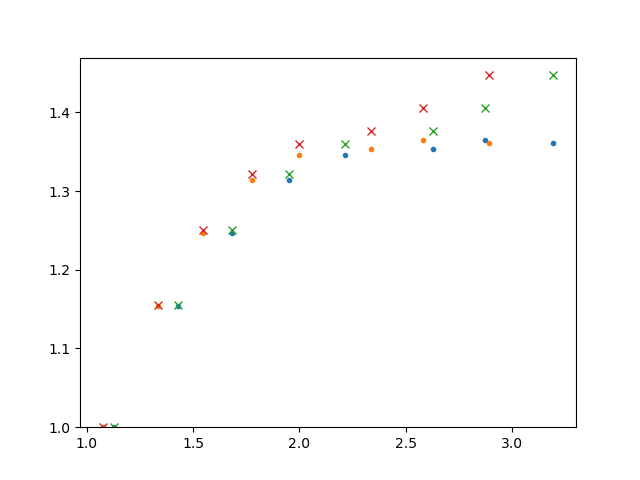

(1.0, 1.4695424096552265)

In [59]:
fig, ax = plt.subplots()
ax.plot(Rcs, VSWR[:,0], '.')
ax.plot(Rcs, VSWR[:,1], 'x')
ax.set_ylim(bottom=1)

In [60]:
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
Rcs_ = np.arange(1, 3, .2)

Rcs, Rcs_ideal, VSWR = [], [], []
for Rc_ in tqdm(Rcs_):
    ff = antenna.TOPICA_front_face(Rc_)
    antenna = WestIcrhAntenna(frequency=freq, front_face=ff)
    antenna.Cs = C_match
    
    # ideal coupling resistance
    Rcs_ideal.append(antenna.front_face_Rc()[freq.center_idx,0])
    # achieved coupling resistance
    Rcs.append(antenna.Rc_WEST(power, phase)[freq.center_idx,:])
    # VSWR
    VSWR.append(antenna.vswr_act(power, phase)[freq.center_idx])

Rcs_ideal = np.array(Rcs_ideal)
Rcs = np.array(Rcs)
VSWR = np.array(VSWR)

<IPython.core.display.Javascript object>


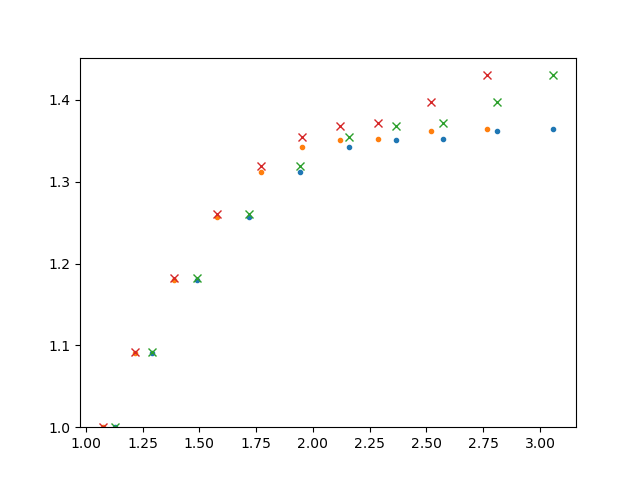

(1.0, 1.4517023162815283)

In [61]:
fig, ax = plt.subplots()
ax.plot(Rcs, VSWR[:,0], '.')
ax.plot(Rcs, VSWR[:,1], 'x')
ax.set_ylim(bottom=1)

In [22]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')